# general imports

In [1]:
from __future__ import division, print_function

import numpy as np
np.random.seed(42)

from scipy.constants import m_p, c, e

import matplotlib.pyplot as plt
%matplotlib inline

from IPython import display

In [2]:
# sets the PyHEADTAIL directory etc.
try:
    from settings import *
except:
    pass

# PyHEADTAIL imports

In [3]:
from PyHEADTAIL.particles.generators import ParticleGenerator, RF_bucket_distribution, gaussian2D
from PyHEADTAIL.trackers.longitudinal_tracking import RFSystems
from PyHEADTAIL.trackers.rf_bucket import RFBucket

PyHEADTAIL v1.10.5.271




# Setting up the machine and functions

In [4]:
# General
macroparticlenumber = int(2e3)

# Machine
C = 100*2*np.pi
R = C/(2*np.pi)

p0 = 1.4e9 * e/c
gamma  = np.sqrt(1 + (p0/(m_p*c))**2)

alpha  = 0.027
eta    = alpha - 1/gamma**2
V      = [40e3, 0, 0.]
h      = [7, 14, 21]
phi   = [np.pi, 0., np.pi]

# Acceleration
beta          = np.sqrt(1-1/gamma**2)
T0            = C/(beta*c)
normalisation = 1/C * e/p0 * T0
dp            = 0. * e/p0 * 1./(beta*c) #* normalisation

# Beam parameters
intensity = 1e10
sigx = 1e-4
sigy = 1e-4
sigz = 9.
sigdp = 9e-4

epsn_z = sigz * sigdp * 4 * np.pi * p0/e
p_increment = dp * p0

# Bunch splitting
n_turns = 3800
ntrns_start = 100
ntrns_rd_0 = 700
ntrns_rd_1 = 2800
ntrns_flat = 3500

# Voltage programs
v0_1 = np.linspace(40e3, 20e3, ntrns_rd_1-ntrns_rd_0)
v0_2 = np.linspace(20e3, 0, ntrns_flat-ntrns_rd_1)
v0 = np.ones(n_turns)*40e3
v0[ntrns_rd_0:ntrns_rd_1] = v0_1[:]
v0[ntrns_rd_1:ntrns_flat] = v0_2[:]
v0[ntrns_flat:n_turns] = 0.

v1_1 = np.linspace(0, 40e3, ntrns_rd_0-ntrns_start)
v1_2 = np.linspace(40e3, 0, ntrns_flat-ntrns_rd_1)
v1 = np.ones(n_turns)*40e3
v1[ntrns_start:ntrns_rd_0] = v1_1[:]
v1[ntrns_rd_1:ntrns_flat] = v1_2[:]
v1[ntrns_flat:n_turns] = 0.
v1[:ntrns_start] = 0.

v2_1 = np.linspace(0, 40e3, ntrns_rd_1-ntrns_start)
v2 = np.ones(n_turns)*40e3
v2[ntrns_start:ntrns_rd_1] = v2_1[:]
v2[:ntrns_start] = 0.

# Let's go

PyHEADTAIL allows to flexibly adjust simulation parameters during running. This enables e.g. to simulate the triple splitting process applied in the CERN Proton Synchrotron: https://cds.cern.ch/record/453506

The following simulation takes ~20 minutes to finish and shows live the beam evolution during the process. The plots present 

1. the voltage programmes of the three harmonics with a cursor for the current time,
2. the current potentials of the three harmonics and
3. the current longitudinal macro-particle phase space distribution.

(Uncomment the `savefig` command to store the plots.)

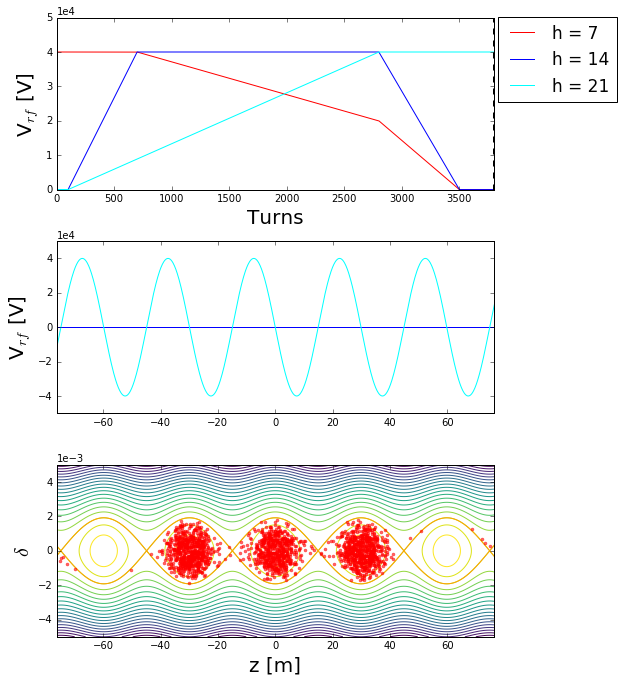

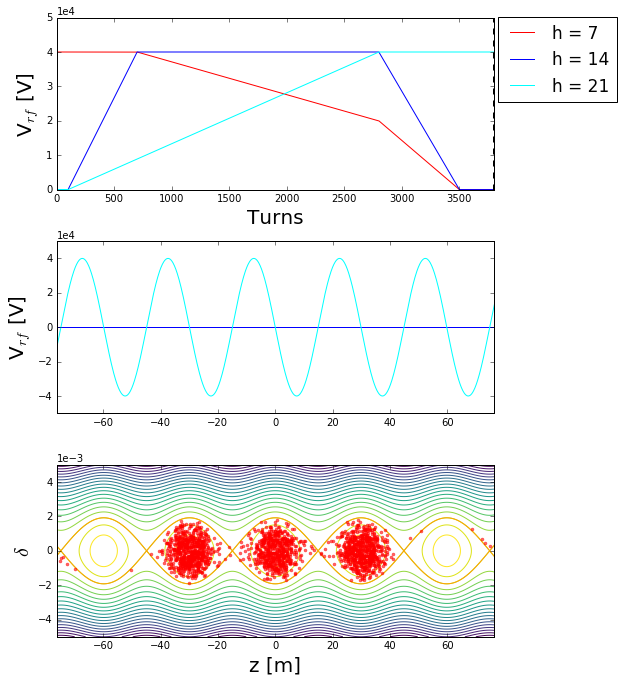

In [5]:
longitudinal_map = RFSystems(
    C, h, V, phi, [alpha], gamma, 
    p_increment=p_increment, charge=e, mass=m_p)
rfbucket = longitudinal_map.get_bucket(gamma=gamma)

beam = ParticleGenerator(
    macroparticlenumber, intensity, e, m_p, C, gamma, 
    distribution_x=gaussian2D(sigx),
    distribution_y=gaussian2D(sigy),
    distribution_z=RF_bucket_distribution(rfbucket, sigma_z=sigz)
).generate()


n_part_vect = []
trns_vect = []
for i in range(n_turns):
    V[0] = v0[i]
    V[1] = v1[i]
    V[2] = v2[i]
    longitudinal_map.voltages = V
    rfbucket = longitudinal_map.get_bucket(beam)        
    longitudinal_map.track(beam)

    zmax   = C/min(h)/2.
    zz = np.linspace(-1.8*zmax, 1.8*zmax, 1000)
    zzsep = np.linspace(-zmax, zmax, 1000)
    pp = np.linspace(-5e-3, 5e-3, 1000)
    ZZ, PP = np.meshgrid(zz, pp)

    mskdp = (beam.dp > -np.max(rfbucket.separatrix(zzsep))) & (beam.dp < np.max(rfbucket.separatrix(zzsep)))
    msk = mskdp
    n_part = np.sum(msk)
    n_part_vect.append(n_part)
    trns_vect.append(i)

    hh = rfbucket.hamiltonian(ZZ, PP)
    zsfp, zufp = rfbucket.z_sfp, rfbucket.z_ufp
    z0 = np.array([z for z in zsfp] + [z for z in zufp])

    if i%10 == 0:
        plt.close('all')
        fig1 = plt.figure(figsize=(9,10))
        ax2 = fig1.add_subplot(311)
        ax1 = fig1.add_subplot(312)
        ax3 = fig1.add_subplot(313, sharex=ax1)

        ax2.set_xlim(0, n_turns)
        ax2.plot(range(n_turns), v0, c='red', label='h = 7')
        ax2.plot(range(n_turns), v1, c='blue', label='h = 14')
        ax2.plot(range(n_turns), v2, c='cyan', label='h = 21')
        ax2.set_ylim(0., 50e3)
        ax2.set_ylabel(r'V$_{rf}$ [V]', fontsize=20)
        ax2.axvline(i, c='black', lw=1, ls='dashed')
        ax2.set_xlabel('Turns', fontsize=20)
        ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        ax2.legend(fontsize=17, loc='upper right', bbox_to_anchor=(1.3, 1.05))

        ax1.plot(zz, V[0]*np.sin(h[0]*zz/R + phi[0]), c='red')
        ax1.plot(zz, V[1]*np.sin(h[1]*zz/R + phi[1]), c='blue')
        ax1.plot(zz, V[2]*np.sin(h[2]*zz/R + phi[2]), c='cyan')
        ax1.set_ylabel(r'V$_{rf}$ [V]', fontsize=20)
        ax1.set_ylim(-50e3, 50e3)
        ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

        ax3.contour(ZZ, PP, hh, 20, cmap=plt.cm.viridis_r)
        ax3.plot(zz, rfbucket.separatrix(zz), c='orange')
        ax3.plot(zz, -rfbucket.separatrix(zz), c='orange')

        ax3.set_xlabel('z [m]', fontsize=20)
        ax3.set_ylabel('$\delta$', fontsize=20)
        ax3.set_xlim(-1.7*zmax, 1.7*zmax)
        ax3.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

        ax3.set_ylim(-0.005, 0.005)
        ax3.plot(beam.z, beam.dp, '.', c='r', alpha=0.6)

        plt.subplots_adjust(bottom=0.07, top=0.93, hspace=0.3, right=0.8)
#         plt.savefig('track_{:04d}.png'.format(i), dpi=70)

        display.clear_output(wait=True)
        display.display(plt.gcf())